# SECAR Focal Plane

The purpose of the example is to show more complex examples of event building and how the framework of sauce allows these operations to be carried out with dataframes. The paper can be consulted for more details, but it is important to note the following:

1) The DAQ consists of two separate crates. One of these crates is located at the gas target at the beginning of the recoil separator and the other 40 meters downstream of the beam at the final focal plane.

2) There is a double sideded silicon strip detector (dssd) with 32 strips on the back and front of the detector.

3) There are two microchannel plate detectors (mcp) located roughly 1.5 meters apart. Each mcp has 4 corner signals and a separate anode timing signal.


In [1]:
import sauce
import matplotlib.pyplot as plt
import polars as pl

It is impractial to define all of these detectors by hand as was done in the $^{241}$Am example; thus, a map file has been provided that lists the location and name of each detector in the system. From this we make two lists, one for the front and one for the back, that contain each of the strips. 

In [2]:
# not that it is dramatically faster to load the run into memory than to extract strip
# by strip off of disk
run_data = sauce.Run("secar_focal_plane.parquet")


def make_dssd(run_data, map_file, side):
    column_map = {}
    detectors = []
    with open(map_file, "r") as f:
        for line in f:
            line = line.split()
            if not column_map:
                for i, column in enumerate(line):
                    column_map[column] = i
                continue
            if line and line[column_map["side"]] == side:
                strip = line[column_map["strip"]]
                print(f"\r{side}:{strip}", end="\r", flush=True)
                crate = line[column_map["crate"]]
                channel = line[column_map["channel"]]
                module = line[column_map["slot"]]
                detectors.append(
                    sauce.Detector(side + strip).find_hits(
                        run_data, crate=int(crate), channel=int(channel), module=int(module)
                    ).tag(int(strip), tag_name="strip")
                )
    return detectors

In [3]:
front = make_dssd(run_data, "map_file.txt", "front")
print()
back = make_dssd(run_data, "map_file.txt", "back")

front:11


Now that we have all of the dssd data, we would like to combine it so that we can start treating the front and back as separate detectors. This requires gain matching. For this data set we luckly have a $^{148}$Gd source that is sitting unaffected by the mcp foils. Firsts lets look at the front spectra.

Text(0.5, 0, '$E$(Channel)')

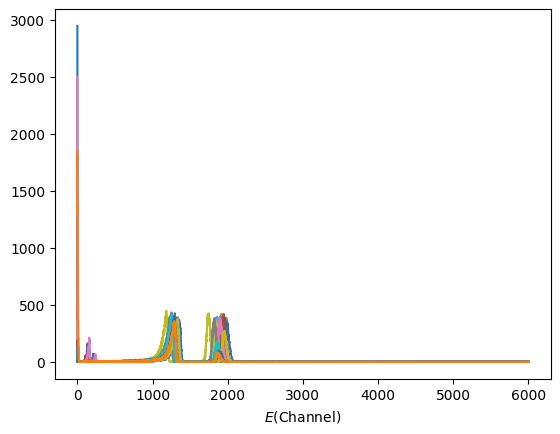

In [4]:
for det in front:
    plt.step(*det.hist(0, 6000, 6000))
plt.xlabel("$E$(Channel)")

We clearly need to apply a threshold, but we will wait until after we have energy calibrated. The $^{241}$Am peak is around channel 2000. We only care about a crude energy calibration, so lets just take the peak centroid / 4.6 MeV. The actual energy of this peak is lower due to entrance windows to the ionization chamber (not used here). We use lmfit to performa a Gaussian fit with linear background.

In [5]:
from lmfit.models import GaussianModel, LinearModel

for det in front:
    x, y = det.hist(1500, 2500, 1000)
    peak = GaussianModel()
    params = peak.guess(y, x=x)
    bkg = LinearModel()
    params.update(bkg.guess(y, x=x))
    model = peak + bkg
    r = model.fit(y, params, x=x)
    # r.plot_fit()
    # plt.xlabel("$E$(Channel)")
    # plt.show()
    # we can go ahead and add the energy column
    det["energy"] = det["adc"] * 4600.0 / r.best_values["center"]
    
    

In [6]:
# works well enought for the back as well.
for det in back:
    x, y = det.hist(1500, 2500, 1000)
    peak = GaussianModel()
    params = peak.guess(y, x=x)
    bkg = LinearModel()
    params.update(bkg.guess(y, x=x))
    model = peak + bkg
    r = model.fit(y, params, x=x)
    # r.plot_fit()
    # plt.xlabel("$E$(Channel)")
    # plt.show()
    det["energy"] = det["adc"] * 4600.0 / r.best_values["center"]

Now that we have an energy calibration, lets apply a cut to get rid of the low energy noise and everything above the $^{148}$Gd line.

In [7]:
for f, b in zip(front, back):
    f.apply_cut((100.0, 6000.0), "energy")
    b.apply_cut((100.0, 6000.0), "energy")

Text(0.5, 0, '$E$(Channel)')

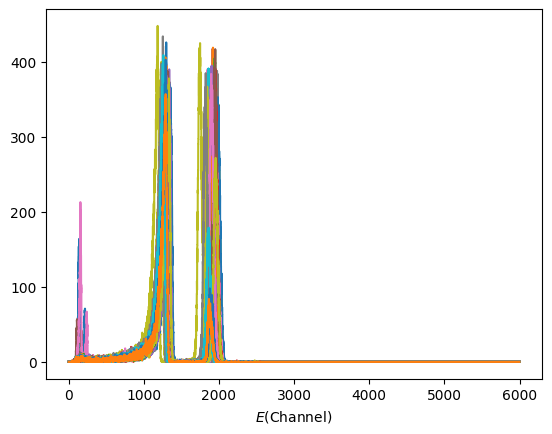

In [8]:
for det in front:
    sauce.utils.step(*det.hist(0, 6000, 6000))
plt.xlabel("$E$(Channel)")

So whats going on here? We still have some noise that crosses the threshold of 100 keV? The answer is that some of the alpha particle will strike betweeen the strips, leading to partial energy deposition in adjacent strips. Correcting for this requires a plan:

1) Use referenceless event building to turn out lists of detectors into a single detector object (we have already tagged the stips).

2) Check on events with multiplicity >1, is there evidence of energy sharing?

3) Sum the energy sharing events, and drop any remaining noise.

In [9]:
front = sauce.detector_union("front", *front)
back = sauce.detector_union("back", *back)

In [10]:
front.build_referenceless_events(500.0)
back.build_referenceless_events(500.0)

Lets see some of the multiplicity 2 events and plot the energies versus one another.

In [11]:
mult2 = front.copy().apply_cut((1, 3), "multiplicity")

Text(0, 0.5, '$E$ Second Strip (keV)')

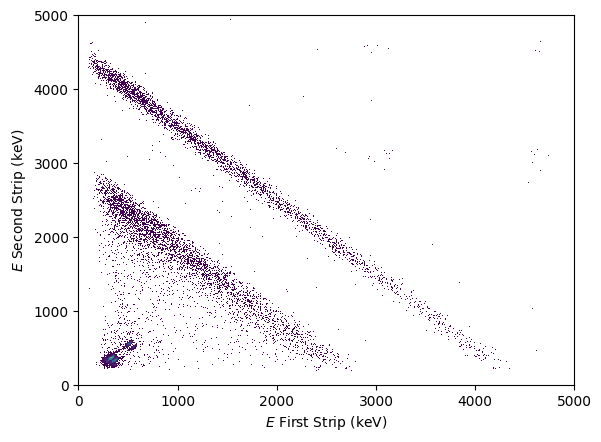

In [12]:
sauce.utils.hist2d(mult2["energy"][::2], mult2["energy"][1::2], bins=500, range=[[0, 5000], [0, 5000]])
plt.xlabel("$E$ First Strip (keV)")
plt.ylabel("$E$ Second Strip (keV)")

So there are energy sharing events, but that is not the apparent cause of the low energy noise. Lets what happens if we naively just sum the strips together and see the effect versus multiplicity.

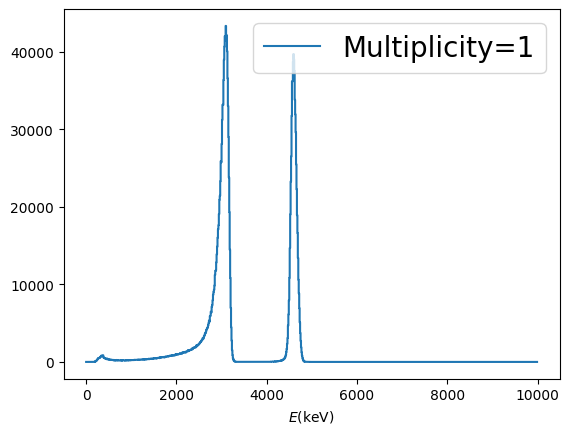

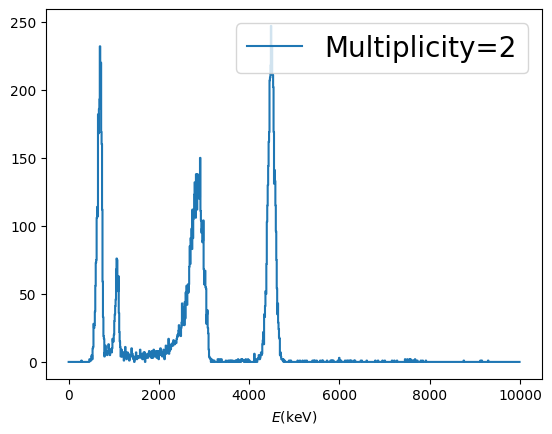

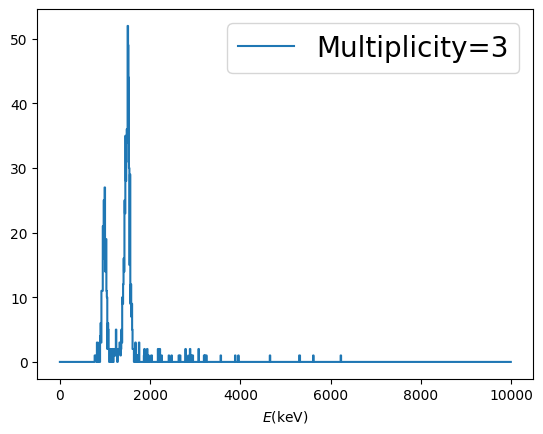

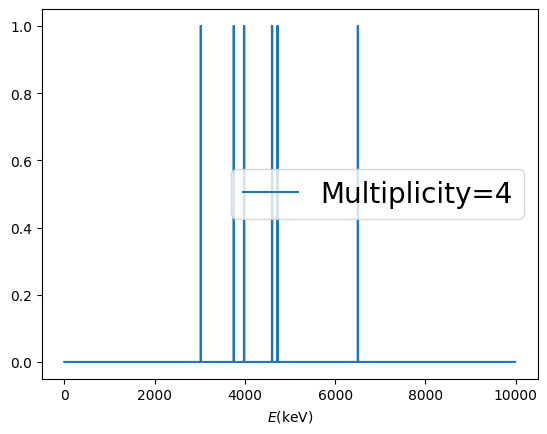

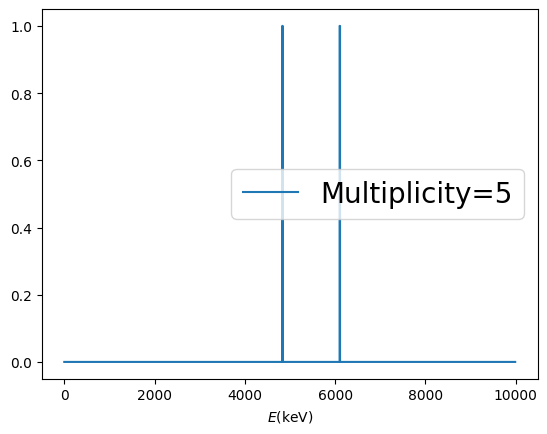

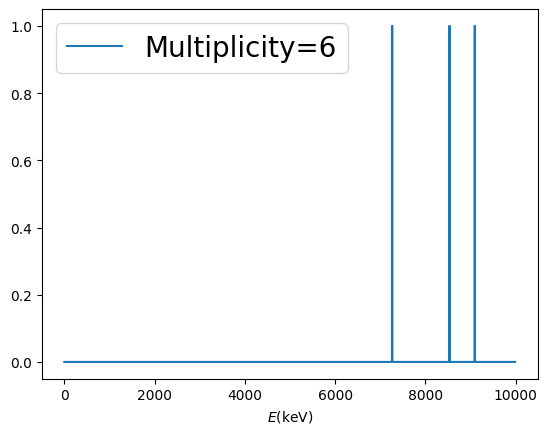

/home/caleb/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/ctypeslib.py:526: RuntimeWarning: A builtin ctypes object gave a PEP3118 format string that does not match its itemsize, so a best-guess will be made of the data type. Newer versions of python may behave correctly.
  return asarray(obj)


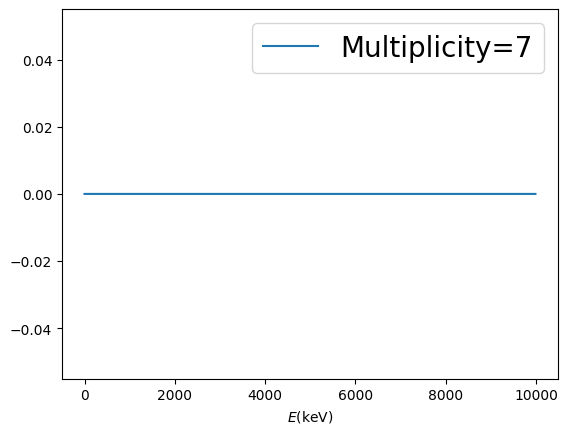

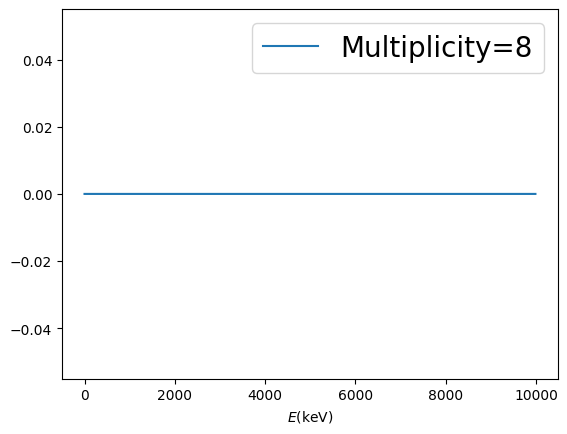

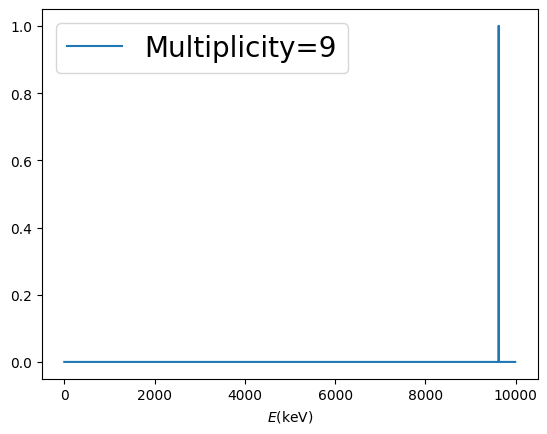

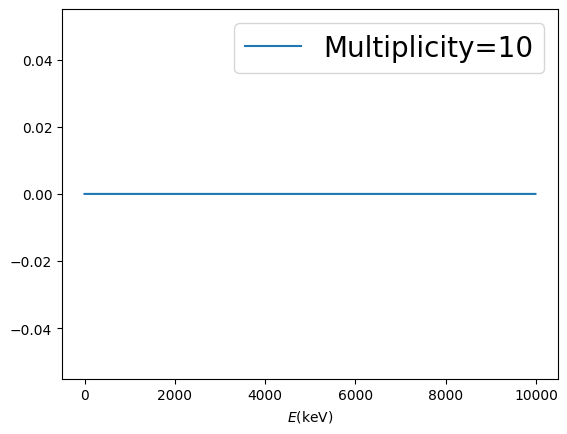

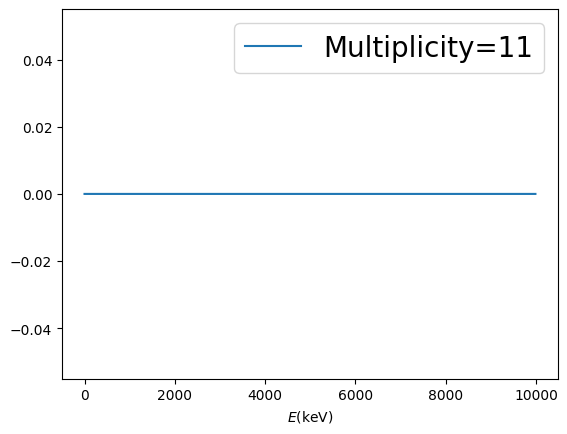

In [13]:
for i in range(1, front["multiplicity"].max()):
    temp = front.copy().apply_cut((i - 1, i +1), "multiplicity")
    temp.data = temp.data.group_by("event_front").agg(energy_sum = pl.col("energy").sum())
    sauce.utils.step(*temp.hist(0, 10000, 1000, "energy_sum"))
    plt.xlabel("$E$(keV)")
    plt.legend([f"Multiplicity={i}"], fontsize=20)
    plt.show()

Nothing exciting seems to happen with the higher multiplicities, so it seems to be the case that we just need to correct for the interstrip hits.

In [14]:
# group by on the detector data frame
def clean_up_data(detector):
    detector.data = (
        detector.data.group_by(f"event_{detector.name}")
        .agg(
            pl.col("strip").get(
                pl.col("energy").arg_max()
            ),  # keep the strip with the max energy
            pl.col("multiplicity").max(),  # all the multiplicities should be the same
            pl.col("energy").sum(),  # just sum
            pl.col("adc").sum(),  # just sum
            pl.col("evt_ts").min(),  # keep the first timestamp
        )
        .filter(pl.col("multiplicity") <= 2)
        .sort("evt_ts")
    )  # drop higher multiplicities, and ensure timestamps are sorted.


clean_up_data(front)
clean_up_data(back)

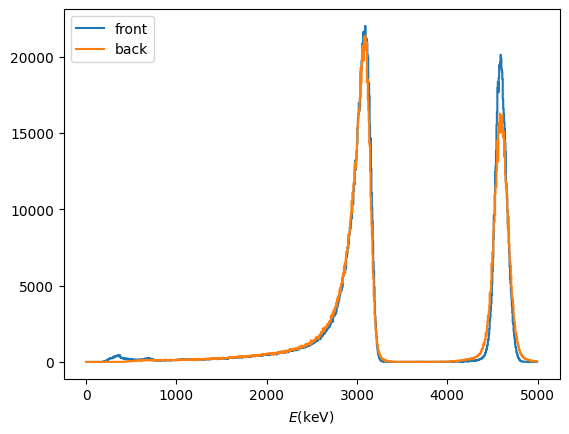

In [15]:
plt.step(*front.hist(0, 5000, 1000, "energy"), label="front")
plt.step(*back.hist(0, 5000, 1000, "energy"), label="back")
plt.xlabel("$E$(keV)")
plt.legend()

Start of the MCP section.

In [16]:
def make_mcp(name, run_data, channels):
    corners = ["A", "B", "C", "D"]
    mcp: sauce.Detector = sauce.detector_union(
        name,
        *[
            sauce.Detector("")
            .find_hits(run_data, crate=1, module=2, channel=channel)
            .apply_threshold(2.0)
            .tag(corner, tag_name="corner")
            for channel, corner in zip(channels, corners)
        ]
    )
    return mcp.build_referenceless_events(500.0)

In [17]:
umcp = make_mcp("umcp", run_data, [4, 5, 6, 7])
dmcp = make_mcp("dmcp", run_data, [8, 9, 10, 11])

We need to select only the events that have four corners that fire.

In [18]:
def mcp_drop_partial_events(mcp: sauce.Detector):
    df: pl.DataFrame = mcp.data
    df = df.with_columns(
        pl.col("corner").n_unique().over("event_" + mcp.name).alias("n_corner")
    )
    df = df.filter(pl.col("n_corner") == 4)
    df = df.unique(["corner", "event_" + mcp.name], maintain_order=True, keep="first")
    mcp.data = df
    return mcp

In [19]:
mcp_drop_partial_events(umcp)
mcp_drop_partial_events(dmcp)


At this point we know that each mcp has only events that are four elements long. A position can be calculated for each event. 

In [20]:
def get_corner(df, corner):
    return df.filter(pl.col("corner") == corner)["adc"]


def calc_pos(mcp):
    q_a = get_corner(mcp.data, "A")
    q_b = get_corner(mcp.data, "B")
    q_c = get_corner(mcp.data, "C")
    q_d = get_corner(mcp.data, "D")

    denom = q_a + q_b + q_c + q_d

    x_raw = ((q_b + q_c) / denom - 0.5) * 8.0
    y_raw = ((q_a + q_b) / denom - 0.5) * 8.0

    mcp.data = mcp.data.group_by("event_" + mcp.name, maintain_order=True).agg(
        pl.col("adc").mean(),
        pl.col("evt_ts").min(),
    )
    
    mcp["x_raw"] = x_raw
    mcp["y_raw"] = y_raw
    
    return mcp


calc_pos(umcp)
calc_pos(dmcp)

The final portion of cleaning is to reduce the other columns and take the earliest timestamp and the mean of the position energies.

As a reward for our extensive data filtering, lets look at a 2d histogram of the positions.

Text(0, 0.5, 'Vertical Position (arb. units)')

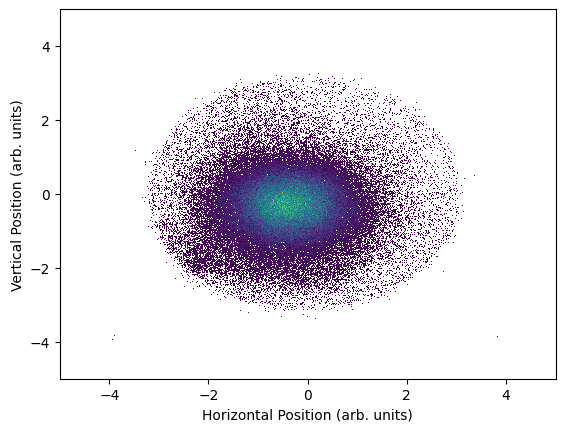

In [21]:
sauce.utils.hist2d(umcp["x_raw"], umcp["y_raw"], bins=1000, range=[[-5, 5], [-5, 5]])
plt.xlabel("Horizontal Position (arb. units)")
plt.ylabel("Vertical Position (arb. units)")

Text(0, 0.5, 'Vertical Position (arb. units)')

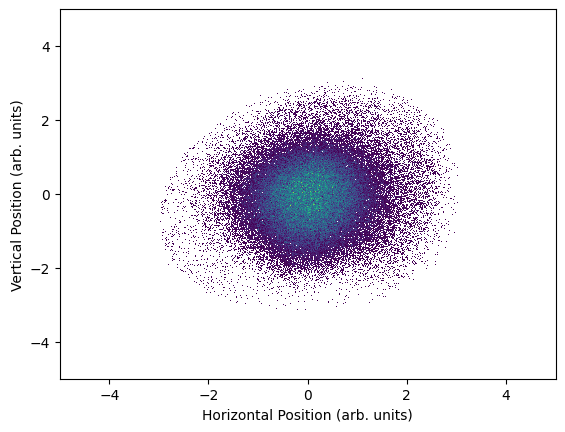

In [22]:
sauce.utils.hist2d(dmcp["x_raw"], dmcp["y_raw"], bins=1000, range=[[-5, 5], [-5, 5]])
plt.xlabel("Horizontal Position (arb. units)")
plt.ylabel("Vertical Position (arb. units)")

These positions are arbitrary, and would need to be calibrated using a mask with known dimensions. Now that we have 4 detectors: front dssd, back dssd, upstream mcp, and downstream mcp we can start looking at coincidences. 

In [23]:
# referenced event builder
eb = sauce.EventBuilder()
eb.add_timestamps(front)
eb.create_build_windows(-500, 500)

# construct coincidecnes
coin = sauce.Coincident(eb)
all_4 = coin[front, back, umcp, dmcp]
# "~" before a detector object means look for anti-coincidences
anti_coin = coin[front, back, ~umcp, ~dmcp]


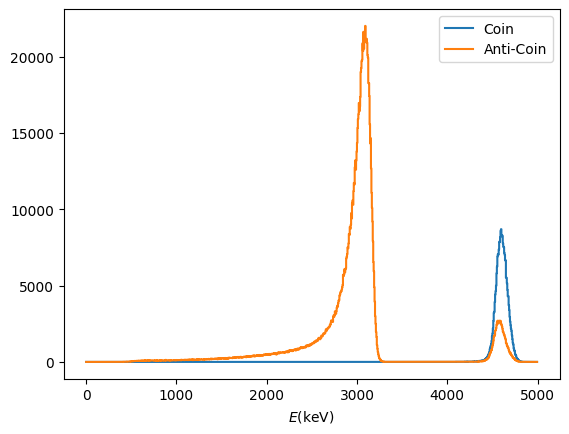

In [24]:
plt.step(*all_4.hist(0, 5000, 1000, "energy_front"), label="Coin")
plt.step(*anti_coin.hist(0, 5000, 1000, "energy_front"), label="Anti-Coin")
plt.xlabel("$E$(keV)")
plt.legend()

So as expected, there are no $^{148}$Gd coincidences. The $^{241}$Am peak cannot be fully removed due to the limited effeciency of the MCP detectors. Lets see what the hit pattern in the dssd looks like for the anti-coincidences if we look only at the $^{241}$Am peak.

Text(0, 0.5, 'Vertical Position (strip)')

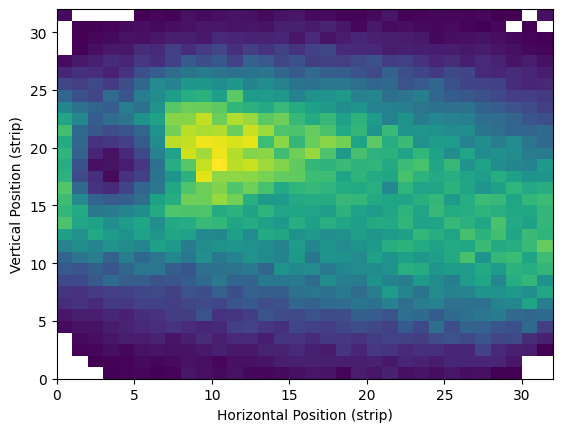

In [25]:
cut = anti_coin.copy()
cut.apply_cut((4000, 5000), "energy_front")
plt.hist2d(
    cut["strip_front"],
    cut["strip_back"],
    bins=(32, 32),
    range=[[0, 32], [0, 32]],
    cmin=1,
)
plt.xlabel("Horizontal Position (strip)")
plt.ylabel("Vertical Position (strip)")

There is a clear non-central distribution. Lets look at just the X-projection, which are the front strips.

Text(0.5, 0, 'Horizontal Position (strip)')

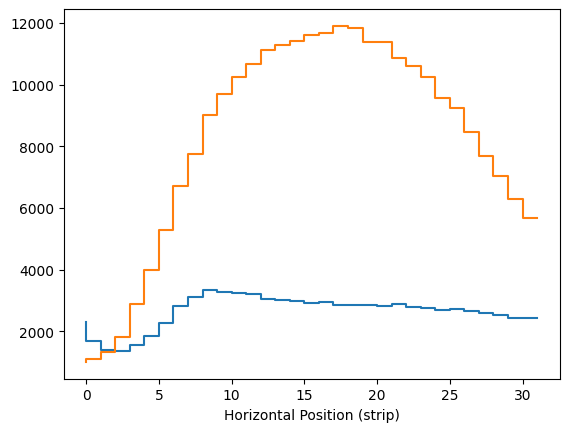

In [26]:
cut_coin = all_4.copy().apply_cut((4000, 5000), "energy_front")


plt.step(*cut.hist(0, 32, 32, "strip_front"))
plt.step(*cut_coin.hist(0, 32, 32, "strip_front"))
plt.xlabel("Horizontal Position (strip)")

One last item to discuss is 2D gating. An interactive API is availible in sauce.gates.Create2DGate, but is unavaliable in notebooks. However, gate objects can be saved to json and loaded. 

In [27]:
g = sauce.gates.Gate2D.load("example_2d_gate.json")
print(g.x_col, g.y_col)

x_raw_umcp y_raw_umcp


We can see that this gate is on the positions of the umcp. We can visualize it with a function in the utils module. It is a gate on the center approximate center of the umcp.

Text(0, 0.5, 'Vertical Position (arb. units)')

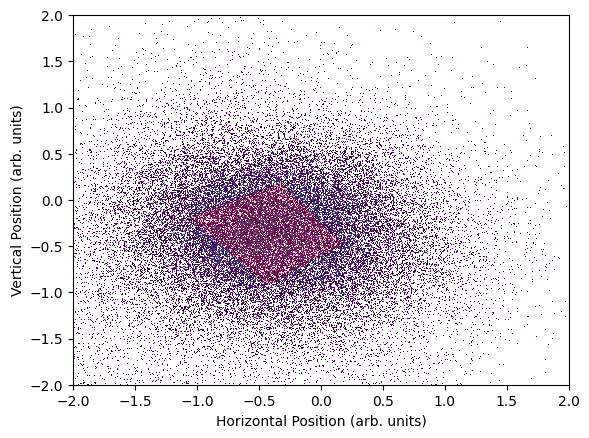

In [28]:
sauce.utils.gate2d(all_4["x_raw_umcp"], all_4["y_raw_umcp"], g, bins=1000, range=[[-2, 2], [-2, 2]], cmin=1)
plt.xlabel("Horizontal Position (arb. units)")
plt.ylabel("Vertical Position (arb. units)")

Now we can apply this gate and look at the result in the front dsssd position and energy.


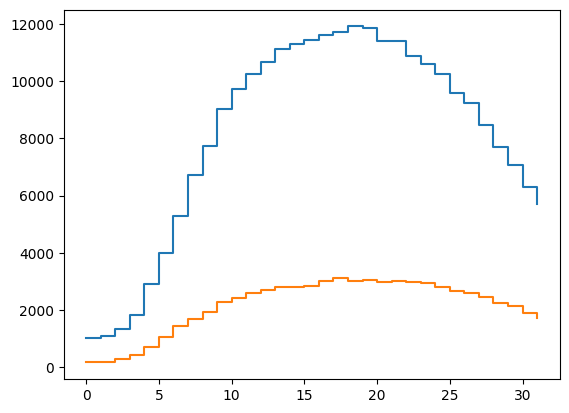

In [29]:
cut_2d = all_4.copy().apply_poly_cut(g)
sauce.utils.step(*all_4.hist(0, 32, 32, "strip_front"))
sauce.utils.step(*cut_2d.hist(0, 32, 32, "strip_front"))

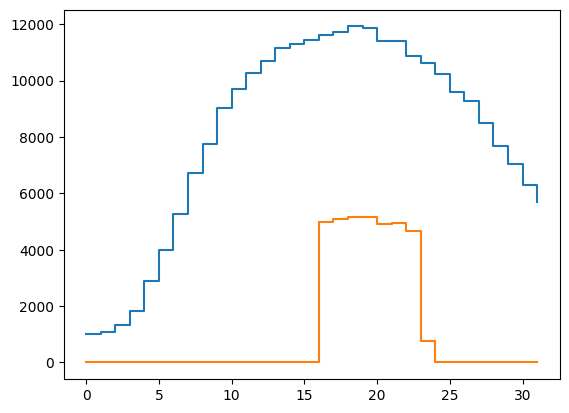

In [30]:
g_dsssd = sauce.gates.Gate2D.load("example_2d_gate_dsssd.json")
cut_2d = all_4.copy().apply_poly_cut(g_dsssd)
sauce.utils.step(*all_4.hist(0, 32, 32, "strip_front"))
sauce.utils.step(*cut_2d.hist(0, 32, 32, "strip_front"))

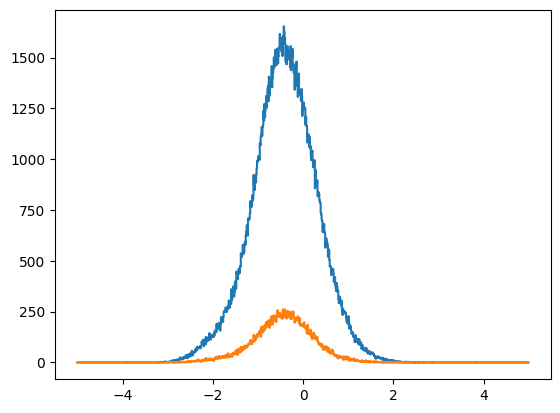

In [31]:
sauce.utils.step(*all_4.hist(-5, 5, 1000, "x_raw_umcp"))
sauce.utils.step(*cut_2d.hist(-5, 5, 1000, "x_raw_umcp"))